# AB Testing for Cookie Cat Game

### **Loading Data and Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
df = pd.read_csv (r'cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### **Data Types**

In [ ]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [ ]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


In [ ]:
df["retention_1"]= df["retention_1"].astype ("int")
df["retention_7"]= df["retention_7"].astype ("int")

### **Missing Values**

In [ ]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### **Find Parameters**

In [ ]:
duplicate_num = df.duplicated(subset = "userid").sum()
duplicate_num

0

In [ ]:
df.shape

(90189, 5)

In [ ]:
mean_sum_gamerounds = df ["sum_gamerounds"].mean()
mean_sum_gamerounds

51.8724567297564

In [ ]:
var_sum_gamerounds = df.loc[:,"sum_gamerounds"].var()
var_sum_gamerounds

38044.8370278758

In [ ]:
min_sum_gamerounds = df["sum_gamerounds"].min()
min_sum_gamerounds

0

In [ ]:
max_sum_gamerounds = df["sum_gamerounds"].max()
max_sum_gamerounds

49854

In [ ]:
quantile_sum_gamerounds = df.sum_gamerounds.quantile([0.25,0.75])
quantile_sum_gamerounds

0.25     5.0
0.75    51.0
Name: sum_gamerounds, dtype: float64

In [ ]:
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

### **Data Prepration**

In [ ]:
df1 = df.pivot(index = "userid", columns= "version", values = "sum_gamerounds")
df1

version,gate_30,gate_40
userid,,
116,3.0,NaN
337,38.0,NaN
377,NaN,165.0
483,NaN,1.0
488,NaN,179.0
...,...,...
9999441,NaN,97.0
9999479,NaN,30.0
9999710,28.0,NaN


In [ ]:
df1.gate_30.describe()

count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: gate_30, dtype: float64

In [ ]:
df1.gate_40.describe()

count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: gate_40, dtype: float64

### **Finding Outliers**

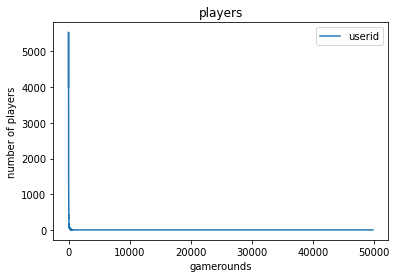

In [ ]:
dfplot = df.groupby("sum_gamerounds")[["userid"]].count()
x = dfplot.plot()
plt.title("players")
plt.xlabel("gamerounds")
plt.ylabel("number of players")
plt.show()

In [ ]:
z_scores = stats.zscore(df['sum_gamerounds'])
z_scores

array([-0.25056402, -0.07112265,  0.5799932 , ..., -0.12239161,
       -0.004473  , -0.18391437])

In [ ]:
dfoutliers = df[(np.abs(z_scores) < 3)]
dfoutliers

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
...,...,...,...,...,...
90184,9999441,gate_40,97,1,0
90185,9999479,gate_40,30,0,0
90186,9999710,gate_30,28,1,0
90187,9999768,gate_40,51,1,0


In [ ]:
dfoutliers['sum_gamerounds'].describe()

count    89764.000000
mean        47.216824
std         80.655584
min          0.000000
25%          5.000000
50%         16.000000
75%         50.000000
max        637.000000
Name: sum_gamerounds, dtype: float64

### **Retention Analysis**

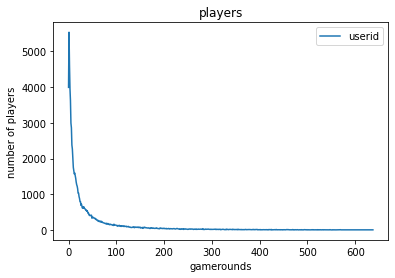

In [ ]:
dfplotoutliers = dfoutliers.groupby("sum_gamerounds")[["userid"]].count()
x = dfplotoutliers.plot()
plt.title("players")
plt.xlabel("gamerounds")
plt.ylabel("number of players")
plt.show()

In [ ]:
dfretention = dfoutliers[["retention_1","retention_7"]].mean()*100
print(f"dfoutliers retention1 = {round(dfretention[0],2)}% \ndfoutliers retention7 = {round(dfretention[1],2)}%")

dfoutliers retention1 = 44.28% 
dfoutliers retention7 = 18.24%


In [ ]:
dfretention = dfoutliers[["retention_1","retention_7"]].sum()
dfretention

retention_1    39744
retention_7    16370
dtype: int64

In [ ]:
dfretentionab = dfoutliers.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
dfretentionab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44500,0.445933,0.186764,2113149
gate_40,45264,0.439643,0.178044,2125222


In [ ]:
lretention1 = []
for q in range (len(dfoutliers)):
    retmean1 = dfoutliers.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    lretention1.append(retmean1)

In [ ]:
dfretmean1 = pd.DataFrame(lretention1)

In [ ]:
dfretmean1['diff'] = ((dfretmean1['gate_30'] - dfretmean1['gate_40']) / dfretmean1['gate_40'] * 100)
dfretmean1

version,gate_30,gate_40,diff
retention_1,0.447961,0.438892,2.066419
retention_1,0.445594,0.433378,2.818677
retention_1,0.445057,0.444656,0.090092
retention_1,0.445540,0.439875,1.287881
retention_1,0.447799,0.436384,2.615746
...,...,...,...
retention_1,0.442961,0.438480,1.021867
retention_1,0.445191,0.438514,1.522599
retention_1,0.445424,0.439089,1.442827
retention_1,0.447945,0.439279,1.972821


In [ ]:
dfretmean1.describe()

version,gate_30,gate_40,diff
count,89764.000000,89764.000000,89764.000000
mean,0.445928,0.439634,1.434378
std,0.002350,0.002342,0.760600
min,0.435805,0.428207,-2.015222
25%,0.444355,0.438051,0.922479
50%,0.445938,0.439642,1.430825
75%,0.447501,0.441207,1.947999
max,0.455944,0.449884,5.072788


In [ ]:
lretention7 = []
for p in range (len(dfoutliers)):
    retmean7 = dfoutliers.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    lretention7.append(retmean7)

In [ ]:
dfretmean7 = pd.DataFrame(lretention7)

In [ ]:
dfretmean7['diff'] = ((dfretmean7['gate_30'] - dfretmean7['gate_40']) / dfretmean7['gate_40'] * 100)
dfretmean7

version,gate_30,gate_40,diff
retention_7,0.186675,0.178414,4.630388
retention_7,0.185003,0.178256,3.784905
retention_7,0.189326,0.177837,6.460376
retention_7,0.185688,0.179571,3.406926
retention_7,0.186257,0.180439,3.224675
...,...,...,...
retention_7,0.182931,0.177482,3.070610
retention_7,0.188125,0.180414,4.274375
retention_7,0.191268,0.181123,5.600948
retention_7,0.183699,0.175669,4.570914


In [ ]:
dfretmean7.describe()

version,gate_30,gate_40,diff
count,89764.000000,89764.000000,89764.000000
mean,0.186769,0.178036,4.915559
std,0.001847,0.001796,1.479794
min,0.179436,0.169831,-0.711599
25%,0.185525,0.176825,3.916190
50%,0.186768,0.178034,4.907116
75%,0.188014,0.179248,5.901487
max,0.195793,0.186216,11.877183


In [ ]:
dfoutliers.groupby('version')['retention_1', 'retention_7'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,retention_1,retention_7
version,,
gate_30,0.445933,0.186764
gate_40,0.439643,0.178044


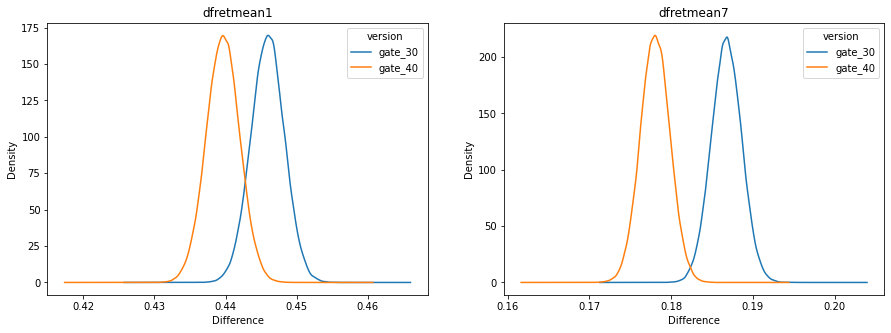

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
dfretmean1.plot(x = "diff", y = ["gate_30", "gate_40"], kind = "kde", ax = ax[0])
dfretmean7.plot(x = "diff", y = ["gate_30", "gate_40"], kind = "kde", ax = ax[1])
ax[0].set_title("dfretmean1")
ax[1].set_title("dfretmean7")
ax[0].set_xlabel("Difference")
ax[1].set_xlabel("Difference")
plt.show()

In [ ]:
probab1 = (dfretmean1['diff']>0).sum()/len(dfretmean1['diff'])
probab7 = (dfretmean7['diff']>0).sum()/len(dfretmean7['diff'])
print (f"probability of retention1 at gate30: {(probab1)*100}%")
print (f"probability of retention7 at gate30: {(probab7)*100}%")

probability of retention1 at gate30: 97.03110378325387%
probability of retention7 at gate30: 99.96212290004902%


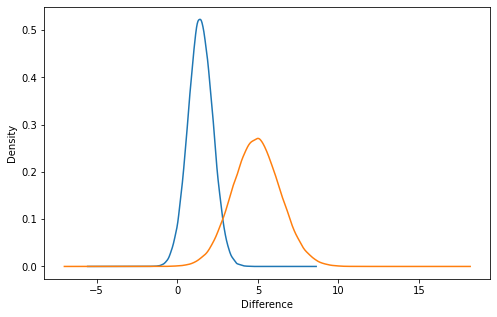

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
dfretmean1['diff'].plot.kde(label = "retention 1")
dfretmean7['diff'].plot.kde(label = "retention 7")
plt.xlabel("Difference")
plt.show()